## DATABASE COMPARISON

NCBI RefSeq: download 09/17/20 <br />
Emu: v2.0 <br />
Datasets: ONT ZymoBIOMICS, MBARC-26 simulated

method: run both on Emu and compare results

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## helper functions


# reduce df to only taxa [index] with at least one val > thresh 
def trim_df_threshold(df, thresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results = df_results[df_results['max'] > thresh]
    df_results = df_results.drop(columns=['max'])
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

def trim_df_threshold_diff(df, maxthresh, minthresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results['min'] = df_results.min(axis=1)
    df_results = df_results[(df_results['min'] < minthresh)|(df_results['max'] > maxthresh)]
    df_results = df_results.drop(columns=['max', 'min'])
    return df_results

def extract_abundance(in_path, rank, in_col, out_col, taxa_col='name', multiplier=1):
    ext = in_path.split(".")[-1]
    if ext == "tsv":
        df_all = pd.read_csv(in_path, sep='\t')
    if ext == "csv":
        df_all = pd.read_csv(in_path)
    df = df_all[[taxa_col, in_col]].groupby(taxa_col).sum().reset_index()
    df = df.rename(columns={in_col:out_col, taxa_col:rank}).dropna()
    df[out_col] = df[out_col] * multiplier
    return df

def extract_abundance_theoretical(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'theoretical', taxa_col=rank)

def extract_abundance_primary(in_path, rank, out_col):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

def extract_abundance_emu(in_path, rank, title):
    return extract_abundance(in_path, rank, 'abundance', title, taxa_col=rank, multiplier=100)

# print L1 and L2 norm for all columns compared to col: 'compare_col_name'
def print_L1_L2(df, compare_col_name):
    df_results = df.copy().fillna(0)
    relative_truth = df_results[compare_col_name]
    df_results = df_results.drop(columns=[compare_col_name])
    df_results = df_results.sub(relative_truth, axis=0).fillna(0)
    df_results_L1 = df_results.applymap(lambda x: abs(x))
    L1 = df_results_L1.sum() * .01
    df_results_L2 = df_results.applymap(lambda x: (x**2))
    L2 = df_results_L2.sum().apply(lambda x: math.sqrt(x)) *.01
    print(f"L1:\n{L1.to_string()}\n")
    print(f"L2:\n{L2.to_string()}\n")
    
# print precision and recall stats for all columns compared to col: 'compare_col_name'
def print_precision_recall(df, compare_col_name):
    df_results = df.copy()
    df_results = df_results.replace(0,np.NaN)
    df_presence = df_results.notnull()
    df_counts = df_presence.sum()
    df_true_positive = df_presence[df_presence[compare_col_name]]
    true_positives = df_true_positive.sum()
    precision = true_positives/df_counts
    sensitivity = true_positives/df_counts[compare_col_name]
    stats = {}
    stats['true_positives'] = df_true_positive.sum()
    stats['false_positives'] = df_counts - true_positives
    stats['precision'] = precision
    stats['recall'] = sensitivity
    stats['f_score'] = 2*precision*sensitivity/(precision+sensitivity)
    display(pd.DataFrame(stats))
    print("\n")


## Mock - ZYMOBIOMICS [D3603] 

source: https://www.mdpi.com/1422-0067/21/1/298/htm   


#### Nanopore
acc: SRR10391201  
#reads: 1,108,690 


#### Illumina (v4-6)
acc: SRR10391187   
#reads: 390,381

In [3]:
## ZymoBIOMICS results - paths

zymo_theoretical_path = "./results_quantitative/truth/zymo_theoretical.csv"

# nanopore truth - primary assignment to restricted db [minimap2]
zymo_nanopore_truth_path = "./results_quantitative/truth/zymo_nanopore_assembled_minimap_primary.tsv"
zymo_nanopore_emu_path = "./results_quantitative/Emu_v2.0.1/zymo_nanopore_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_emu_ncbidb_path = "./results_quantitative/Emu_v2_RefSeq/zymo_ncbidb_rel-abundance-threshold-0.0001.tsv"




L1:
Emu_default    0.001095
Emu_RefSeq     0.075863

L2:
Emu_default    0.000479
Emu_RefSeq     0.049635



true_positives  false_positives  precision  recall   f_score
truth                     8                0   1.000000     1.0  1.000000
Emu_default               8                0   1.000000     1.0  1.000000
Emu_RefSeq                8                6   0.571429     1.0  0.727273

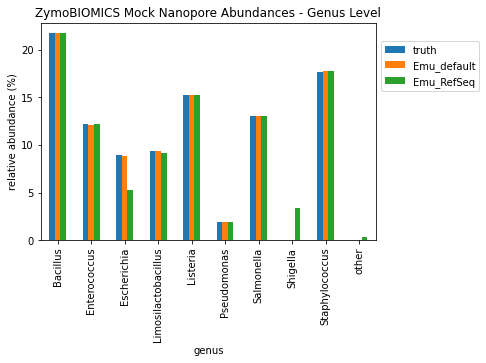

In [4]:
## ZymoBIOMICS Nanopore - Genus Level

zymo_truth_genus = extract_abundance_primary(zymo_nanopore_truth_path, 'genus', 'truth')
zymo_emu_genus = extract_abundance_emu(zymo_nanopore_emu_path, 'genus', 'Emu_default')
zymo_emu_ncbidb_genus = extract_abundance_emu(zymo_nanopore_emu_ncbidb_path, 'genus', 'Emu_RefSeq')


df_results_zymo_nanopore_genus = zymo_truth_genus
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_emu_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_emu_ncbidb_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = df_results_zymo_nanopore_genus.set_index("genus")
df_results_zymo_nanopore_genus.to_csv("./results_db_comp/db_comp_zymo_nanopore_genus_abundances.csv")

df_results_zymo_nanopore_genus_drop_thresh = trim_df_threshold(df_results_zymo_nanopore_genus, 1)
df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.sort_index()
df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.reset_index()

df_results_zymo_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "ZymoBIOMICS Mock Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_genus.jpg", bbox_inches='tight')

print_L1_L2(df_results_zymo_nanopore_genus, 'truth')
print_precision_recall(df_results_zymo_nanopore_genus, 'truth')



L1:
Emu_default    0.034319
Emu_RefSeq     0.792649

L2:
Emu_default    0.021271
Emu_RefSeq     0.317736



true_positives  false_positives  precision  recall   f_score
truth                     8                0   1.000000   1.000  1.000000
Emu_default               8                6   0.571429   1.000  0.727273
Emu_RefSeq                7               27   0.205882   0.875  0.333333

'The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)'

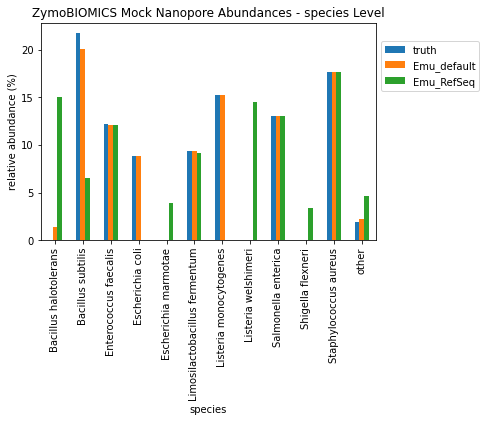

In [5]:
## ZymoBIOMICS Nanopore - species Level

zymo_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth')
zymo_emu_species = extract_abundance_emu(zymo_nanopore_emu_path, 'species', 'Emu_default')
zymo_emu_ncbidb_species = extract_abundance_emu(zymo_nanopore_emu_ncbidb_path, 'species', 'Emu_RefSeq')

df_results_zymo_nanopore_species = zymo_truth_species
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_ncbidb_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = df_results_zymo_nanopore_species.set_index("species")
df_results_zymo_nanopore_species.to_csv("./results_db_comp/db_comp_zymo_nanopore_sp_abundances.csv")


df_results_zymo_nanopore_species_drop_thresh = trim_df_threshold(df_results_zymo_nanopore_species, 2)
df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.sort_index()
df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.reset_index()

df_results_zymo_nanopore_species_drop_thresh.plot.bar(x='species', title = "ZymoBIOMICS Mock Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_species.jpg", bbox_inches='tight')
print_L1_L2(df_results_zymo_nanopore_species, 'truth')
print_precision_recall(df_results_zymo_nanopore_species, 'truth')


"The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)"


## Simulated MBARC

unique species: 26
number of reads: 958,655

In [6]:
## MBARC results - paths

# Nanopore truth - primary assignment to restricted db [minimap2]
mbarc_ncbi_theoretical_path = "./results_quantitative/truth/mbarc_ncbi_theoretical.csv"

mbarc_ncbi_emu_path = "./results_quantitative/Emu_v2.0.1/mbarc_ncbi_rel-abundance.tsv"
mbarc_ncbi_emu_ncbidb_path = "./results_quantitative/Emu_v2_RefSeq/mbarc_ncbidb_rel-abundance.tsv"


L1:
Emu_default    0.000016
Emu_RefSeq     0.000016

L2:
Emu_default    0.000005
Emu_RefSeq     0.000005



true_positives  false_positives  precision  recall  f_score
theoretical              24                0        1.0     1.0      1.0
Emu_default              24                0        1.0     1.0      1.0
Emu_RefSeq               24                0        1.0     1.0      1.0

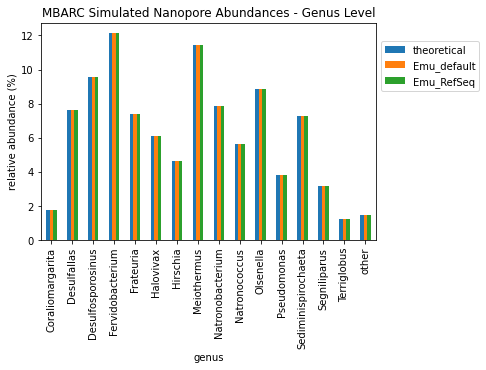

In [7]:
## MBARC Nanopore - Genus Level 

mbarc_ncbi_theoretical_genus = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'genus')
mbarc_emu_genus = extract_abundance_emu(mbarc_ncbi_emu_path,'genus', 'Emu_default')
mbarc_emu_ncbidb_genus = extract_abundance_emu(mbarc_ncbi_emu_ncbidb_path,'genus', 'Emu_RefSeq')

df_results_mbarc_nanopore_genus = mbarc_ncbi_theoretical_genus
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_emu_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_emu_ncbidb_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = df_results_mbarc_nanopore_genus.set_index("genus")
df_results_mbarc_nanopore_genus.to_csv("./results_db_comp/db_comp_mbarc_genus_abundances.csv")

df_results_mbarc_nanopore_genus_drop_thresh = trim_df_threshold(df_results_mbarc_nanopore_genus, 1)
df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.sort_index()
df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.reset_index()

df_results_mbarc_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "MBARC Simulated Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_genus.jpg", bbox_inches='tight')

print_L1_L2(df_results_mbarc_nanopore_genus, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_genus, 'theoretical')


L1:
Emu_default    0.000033
Emu_RefSeq     0.000078

L2:
Emu_default    0.000013
Emu_RefSeq     0.000042



true_positives  false_positives  precision  recall   f_score
theoretical              26                0   1.000000     1.0  1.000000
Emu_default              26                0   1.000000     1.0  1.000000
Emu_RefSeq               26                1   0.962963     1.0  0.981132

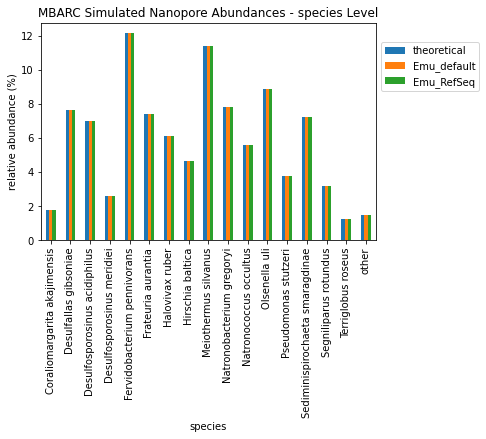

In [8]:
## MBARC Nanopore - species Level

mbarc_ncbi_theoretical_species = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'species')
mbarc_emu_species = extract_abundance_emu(mbarc_ncbi_emu_path, 'species', 'Emu_default')
mbarc_emu_ncbidb_species = extract_abundance_emu(mbarc_ncbi_emu_ncbidb_path, 'species', 'Emu_RefSeq')

df_results_mbarc_nanopore_species = mbarc_ncbi_theoretical_species
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_emu_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_emu_ncbidb_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = df_results_mbarc_nanopore_species.set_index("species")
df_results_mbarc_nanopore_species.to_csv("./results_db_comp/db_comp_mbarc_sp_abundances.csv")

df_results_mbarc_nanopore_species_drop_thresh = trim_df_threshold(df_results_mbarc_nanopore_species, 1)
df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.sort_index()
df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.reset_index()

df_results_mbarc_nanopore_species_drop_thresh.plot.bar(x='species', title = "MBARC Simulated Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_species.jpg", bbox_inches='tight')

print_L1_L2(df_results_mbarc_nanopore_species, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_species, 'theoretical')

## Mock - ZYMOBIOMICS [D3603] 

source: https://www.mdpi.com/1422-0067/21/1/298/htm  
ENA project archieve: https://www.ebi.ac.uk/ena/browser/view/PRJNA587452


#### Nanopore
acc: SRR10391201  
#reads: 1,108,690 



In [9]:
## ZymoBIOMICS results_quantitative - paths

zymo_theoretical_path = "./results_quantitative/truth/zymo_theoretical.csv"

# nanopore truth - primary assignment to restricted db [minimap2]
zymo_nanopore_truth_path = "./results_quantitative/truth/zymo_nanopore_assembled_minimap_primary.tsv"
zymo_nanopore_emu_path = "./results_quantitative/Emu_v2.0.1/zymo_nanopore_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_nanoclust_species_path = "./results_quantitative/nanoclust/rel_abundance_zymo_nanopore_guppy_S.csv"
zymo_nanopore_nanoclust_genus_path = "./results_quantitative/nanoclust/rel_abundance_zymo_nanopore_guppy_G.csv"
zymo_nanopore_centrifuge_path = "./results_quantitative/Centrifuge/zymo_nanopore.classification.kreport.tsv"
zymo_nanopore_kraken_path = "./results_quantitative/kraken2/zymo_nanopore.kreport"
zymo_nanopore_bracken_species_path = "./results_quantitative/Bracken/zymo_nanopore_bracken_species.tsv"
zymo_nanopore_bracken_genus_path = "./results_quantitative/Bracken/zymo_nanopore_bracken_genus.tsv"
zymo_nanopore_minimap_path = "./results_quantitative/Minimap2/zymo_nanopore_minimap2.tsv"
zymo_nanopore_qiime_species_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-species-table.tsv"
zymo_nanopore_qiime_genus_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-genus-table.tsv"
zymo_nanopore_qiime_species_path = "./results_quantitative/Qiime2/zymo_nanopore_derep-rel-species-table.tsv"
zymo_nanopore_metamaps_path = "./results_quantitative/MetaMaps/zymo_nanopore_guppy.EM.WIMP"
